<h1><center>CAPSTONE PROJECT</center></h1>
<h1><center>CLUSTERING TORONTO NEIGHBORHOODS BASED ON SAFETY</center></h1>
<h1><center>HOUSING PRICES, SCHOOLS & ENTERTAINMENT</center></h1>
<h1><center>by</center></h1>
<h1><center>Maryam Momodu Bassey</center></h1>


# Introduction

Canada opened its borders to skilled workers from all over the world. Emigrating skilled workers ofthe come along with their families.  

Locating the right neighborhood to reside in is an issue for people new to a city. There are several factors to consider, the more common being: cost of housing, crime rate, proximity to schools for children and places of entertainment. There are also issues like proximity to work and potential employement opportunities which will not be considered in this work.  

This project aims to use data to help guide Toronto immigrants in choosing neighborhoods to reside with regards to **safety**, **housing prices**, **availability of schools and entertainment activities**. Neighborhoods that share similar attributes with regards to the above listed parameters will be classed together in order to simplify the process of choosing a place to reside within the greater Toronto metropolis.

# Data Requirements

- Toronto crime incidents data including incident type and location data
- Data on average housing prices with regards to neighborhoods in Toronto
- Location data for Schools, Arts and Entertainment centers in Toronto neighborhoods
- Toronto neighborhood latitude and longitude data
- Toronto neighborhood geojson data

# Data Sources

- Housing prices  
Sourced from- https://www.zolo.ca/toronto-real-estate/neighbourhoods, 29/04/19 6.17pm  
The data was scraped from the website and it contains the average selling price of houses for neighborhoods in Toronto for 28days prior to the day it was scraped.  

- Toronto crime data
Sourced from- http://data.torontopolice.on.ca/datasets/98f7dde610b54b9081dfca80be453ac9_0,  28/04/19  
The downloaded dataset contains information on crimes committed in Toronto and their location data from 2014 to 2018. The 2018 incidents data is of interest for this project.  

- Data for schools and entertainment centers in Toronto was sourced from the Four Square Location data.  

- Neighborhood  CDN- https://en.wikipedia.org/wiki/List_of_city-designated_neighbourhoods_in_Toronto  

- Toronto neighborhood Geojson data  
https://github.com/jasonicarter/toronto-geojson/blob/master/toronto_topo.json  
https://portal0.cf.opendata.inter.sandbox-toronto.ca/dataset/neighbourhoods/  


# Data Collection and Cleaning

## Housing Sales Price Data

#### Housing Data Web Scraping

In [ ]:
import requests
from bs4 import BeautifulSoup
import csv
import numpy as np
import pandas as pd
print('Libraries Imported!')

In [ ]:
source= requests.get('https://www.zolo.ca/toronto-real-estate/neighbourhoods').text
soup = BeautifulSoup(source, 'lxml')

csv_file= open('toronto_housing.csv', 'w')
csv_writer= csv.writer(csv_file)
csv_writer.writerow(['Neighborhood', 'AveragePrice'])

for tr in soup.find_all('tr'):
    
    try:
        neighborhood= tr.find('a', class_='xs-block xs-ml3').text
    except Exception as e:
        neigborhood= None
    print(neighborhood)
    

    try:
        price= tr.select('td')[3].text
    except Exception as e:
        price= None
    print(price)
    
    print()

    
    csv_writer.writerow([neighborhood, price])
    
csv_file.close()

#### Cleaning and preparing the dataset

In [ ]:
housing_df= pd.read_csv('toronto_housing.csv')
housing_df.head(15)

In [ ]:
housing_df= housing_df.dropna(axis=0) #dropping rows with missing values

# drop the rows with extrenous data
housing_df= housing_df.drop([1, 2, 3, 4, 5, 7, 8, 9, 10, 11])

housing_df.drop_duplicates(subset='Neighborhood', keep='first', inplace= True)# dropping any duplicates in the dataset
housing_df.head()

In [ ]:
housing_df.to_csv('toronto_housing_edited.csv', index=False) #saving the edited DataFrame to csv

The Housing price dataset was further cleaned manually, removing the symbols and setting all prices to thousands. The neighborhood ID was also added to the csv file.

## Crime incidence dataset

In [ ]:
#reading the downloaded crime incidents datset
crime_df= pd.read_csv('MCI_2014_to_2018.csv')
crime_df.head()

In [ ]:
#Getting colum names
crime_df.columns

In [ ]:
#Selecting needed columns
crime_edited_df= crime_df[['Hood_ID', 'Neighbourhood', 'Lat', 'Long', 'MCI']]
crime_edited_df.head()

Explore and visualize the dataset

In [ ]:
crime_df.shape

In [ ]:
#Getting the laitude and Longitude data for each neighborhood
crime_grouped_df= crime_df[['Hood_ID', 'Lat', 'Long']].groupby(['Hood_ID']).mean()
crime_grouped_df.reset_index(inplace=True)
crime_grouped_df.head()

In [ ]:
# getting the total crime count of each neighborhood
toronto_crime= pd.DataFrame(crime_df['Neighbourhood'].value_counts())
toronto_crime.reset_index(inplace=True)

In [ ]:
toronto_crime.columns=['Neighbourhood', 'Crime count']#renaming the columns
toronto_crime.columns

In [ ]:
#removing () around the neighborhood ID
toronto_crime[['Neighborhood', 'Hood_ID', 'I']]= toronto_crime.Neighbourhood.str.split('(', expand=True)
toronto_crime['Hood_ID']= toronto_crime['Hood_ID'].str.split(')', expand=True)[0]
toronto_crime= toronto_crime.drop(['Neighbourhood', 'I'], axis=1)
toronto_crime.head()

In [ ]:
#merging the crime rate dataset with the latitude and longitude data
toronto_crime_df= pd.merge(crime_grouped_df, toronto_crime, on= 'Hood_ID', how= 'right')
toronto_crime_df.head()

In [ ]:
toronto_crime_df.to_csv('toronto_crime_edited.csv', index=False ) #saving to csv

Visualising the crime dataset with folium

In [ ]:
import folium

In [ ]:
# toronto latitude and longitude values
latitude = 43.65
longitude = -79.38

In [ ]:
import random
#selecting 100 random incidents to display
crime_sampledf= crime_df.iloc[random.sample(range(0,36303), 1000), :]
crime_sampledf.shape

In [ ]:
toronto_map4 = folium.Map(location=[latitude, longitude], zoom_start=12)


# add pop-up text to each marker on the map
latitudes = list(toronto_crime_df.Lat)
longitudes = list(toronto_crime_df.Long)
labels = list(toronto_crime_df['Neighborhood'])

for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker([lat, lng], popup=label).add_to(toronto_map4)    

    # create a numpy array of length 6 and has linear spacing from the minium total immigration to the maximum total immigration
threshold_scale = np.linspace(toronto_crime_df['Crime count'].min(),
                              toronto_crime_df['Crime count'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration

toronto_map4.choropleth(
    geo_data=toronto_geo,
    data=toronto_crime_df,
    columns=['Hood_ID', 'Crime count'],
    key_on='feature.properties.AREA_SHORT_CODE',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Immigration to Canada',
    reset=True
)

In [ ]:
toronto_map4.save('torontomap4.html')

## Arts and Entertainment, Schools data using Four Square API

In [ ]:
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import json # library to handle JSON files

import numpy as np

import pandas as pd

print('Libraries imported.')

Define FourSquare Credentials and version

In [ ]:
CLIENT_ID = 'AOJJ0EB1OUDLATTJHDA3GSURAPZOMOFG3QWKL4L034BFCJZK' # Foursquare ID
CLIENT_SECRET = 'EP5YEA4JJVM2RP40LYWNNBK4DK5ESVTP5JHI23VIQYKV5TXH' # Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 200
radius= 500

print('Your credentails are set!')

#### Explore Neighborhoods in Toronto

Defining a function to get nearby venues of all the neighborhoods in Toronto

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

 Writing the code to run the above function on each neighborhood and create a new dataframe called *toronto_venues*

In [ ]:
toronto_venues = getNearbyVenues(names=hoodcrime_df['Neighborhood'],
                                   latitudes=hoodcrime_df['Lat'],
                                   longitudes=hoodcrime_df['Long']
                                  )

In [ ]:
print(toronto_venues.shape)
toronto_venues.head()

#### Analyze Each Neighborhood

In [ ]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

In [ ]:
print(toronto_onehot.columns) #getting the column names

In [ ]:
#getting specific venues and seperating them

arts_entertainment=['Amphitheater', 'Aquarium', 'Arcade', 'Art Gallery', 'Sports Club', 'Park', 'Recreation Center', 'Playground', 'Bowling Alley', 'Casino', 'Circus', 'Comedy Club', 'Concert Hall','Country Dance Club', 'Disc Golf', 'Exhibit', 'General Entertainment', 'Go Kart Track', 'Historic Site', 'Karaoke Box', 'Laser Tag', 'Memorial Site', 'Mini Golf', 'Drive-in Theater', 'Indie Movie Theater', 'Multiplex', 'Art Museum', 'History Museum', 'Planetarium', 'Science Museum', 'Jazz Club', 'Piano Bar', 'Rock Club', 'Dance Studio', 'Indie Theater', 'Opera House', 'Theater', 'Pool Hall', 'Racecourse', 'Racetrack', 'Roller Rink', 'Salsa Club', 'Samba School', 'Stadium', 'Theme Park', 'Water Park', 'Zoo']
toronto_onehot['Arts_and_Entertainment']=toronto_onehot.loc[:, arts_entertainment].sum(axis=1)

school=['Elementary School', 'High School', 'Middle School', 'Preschool', 'Private School', 'Driving School', 'Nursery School']
toronto_onehot['Schools']=toronto_onehot.loc[:, school].sum(axis=1)

In [ ]:
toronto_onehot1= toronto_onehot[['Neighborhood', 'Arts_and_Entertainment','Schools']]
toronto_onehot1.head()

In [ ]:
hood_art_school= toronto_onehot1.groupby('Neighborhood').sum().reset_index()
hood_art_school.head()

In [ ]:
hood_art_school.to_csv('toronto_art_school.csv', index=False ) #saving the dataset to csv

# Data Preparation

### Merging Datasets

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
#importing clean datasets
hood_art_school= pd.read_csv('toronto_art_school.csv') 
hoodcrime_df= pd.read_csv('toronto_crime_edited.csv')
hood_housing= pd.read_csv('toronto_housing_edited.csv')

print('Entertainment and Schools Dataset size: ', hood_art_school.shape)
print('Toronto 2018 Crime rate Dataset size: ', hoodcrime_df.shape)
print('Average Housing Price Dataset size: ', hood_housing.shape)

In [ ]:
# Getting the column names
print('Entertainment and Schools Dataset columns: ', hood_art_school.columns)
print('Toronto 2018 Crime rate Dataset columns: ', hoodcrime_df.columns)
print('Average Housing Price Dataset columns: ', hood_housing.columns)

In [ ]:
hood_df= pd.merge(hood_housing, hoodcrime_df, on='Hood_ID', how='left') #merging the first 2 datasets

hood_df.drop(['Neighborhood_y'], axis=1, inplace=True) #Dropping the 1 column containing Neighborhood names

neighborhood_df= pd.merge(hood_df, hood_art_school, on='Hood_ID', how='right')#merging the 3rd dataset with the first 2

print(neighborhood_df.shape)
neighborhood_df.head()

In [ ]:
neighborhood_df.drop(['Neighborhood'], axis=1, inplace=True) #Dropping an extra column with Neighborhood names
neighborhood_df.head()

In [ ]:
neighborhood_df.to_csv('Neighborhood_Dataset.csv', index=False ) #saving dataset to csv 

# Methodology

### Visualizing spread of data

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
print('Libraries imported!')

Libraries imported!


In [2]:
neighborhood_df= pd.read_csv('Neighborhood_Dataset.csv')
neighborhood_df.head()

,Neighborhood_x,AveragePrice$x10^3,Hood_ID,Lat,Long,Crime count,Arts_and_Entertainment,Schools
0,Agincourt North,668,129,43.805598,-79.273155,250,1.0,0.0
1,Agincourt South-Malvern West,559,128,43.786654,-79.268895,293,1.0,0.0
2,Alderwood,869,20,43.606141,-79.541045,95,1.0,0.0
3,Annex,1600,95,43.669766,-79.403552,625,4.0,0.0
4,Banbury-Don Mills,922,42,43.735910,-79.346334,200,0.0,0.0


In [46]:
import seaborn as sns

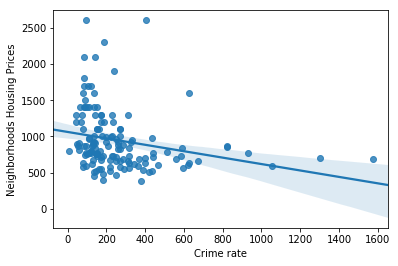

In [51]:
sns.regplot(x='Crime count', y='AveragePrice$x10^3', data=neighborhood_df)
plt.ylabel('Neighborhoods Housing Prices')
plt.xlabel('Crime rate')
plt.show()

The plot above shows that the relationship between housing price and cime rate in Toronto Neighborhoods is non-linear

In [15]:
neighborhood_df.describe()

,AveragePrice$x10^3,Hood_ID,Lat,Long,Crime count,Arts_and_Entertainment,Schools
count,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000
mean,948.914894,70.078014,43.707510,-79.402293,257.468085,0.971631,0.007092
std,417.360729,40.722944,0.050919,0.102288,231.788036,1.535035,0.084215
min,385.000000,1.000000,43.593040,-79.598004,6.000000,0.000000,0.000000
25%,674.000000,35.000000,43.668896,-79.480899,120.000000,0.000000,0.000000
50%,842.000000,70.000000,43.699651,-79.406534,183.000000,1.000000,0.000000
75%,1100.000000,105.000000,43.745742,-79.331694,312.000000,1.000000,0.000000
max,2600.000000,140.000000,43.819970,-79.147630,1575.000000,13.000000,1.000000


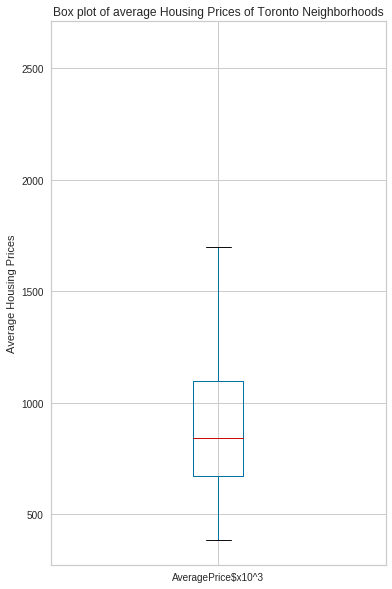

In [61]:
df_housing= neighborhood_df[['Neighborhood_x','AveragePrice$x10^3']].set_index('Neighborhood_x')

df_housing.plot(kind='box', figsize=(6, 10))

plt.title('Box plot of average Housing Prices of Toronto Neighborhoods')
plt.ylabel('Average Housing Prices')

plt.savefig('housingPriceBox.png', bbox_inches='tight')
plt.show()


With the boxplot we can create groups for the housing prices.    
 
- 385 to 674 will be classified as LOW 
- 675 to 842 will be classified as AVERAGE 
- 843 to 1100 will be classified as ABOVE AVERAGE
- 1101 to 1750 will be classified as HIGH
- 1751 to 2600 will be classified as VERY HIGH

 

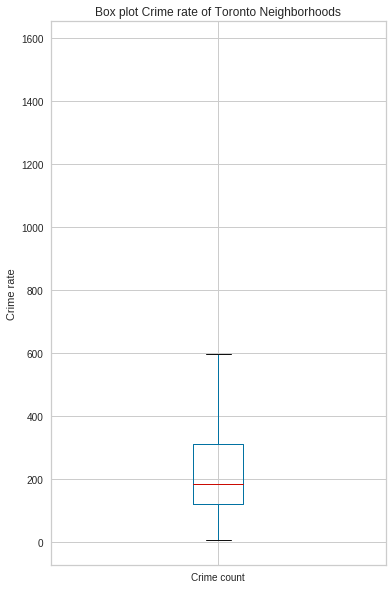

In [56]:
df_crime= neighborhood_df[['Neighborhood_x', 'Crime count']].set_index('Neighborhood_x')
df_crime.plot(kind='box', figsize=(6, 10))

plt.title('Box plot Crime rate of Toronto Neighborhoods')
plt.ylabel('Crime rate')
plt.savefig('crimeRateBox.png')
plt.show()

With the boxplot we can create groups for the Crime rate in Toronto Neighborhoods.    
 
- 6 to 120 will be classified as LOW 
- 121 to 183 will be classified as AVERAGE 
- 184 to 312 will be classified as ABOVE AVERAGE
- 313 to 600 will be classified as HIGH
- 601 to 1575 will be classified as VERY HIGH

 

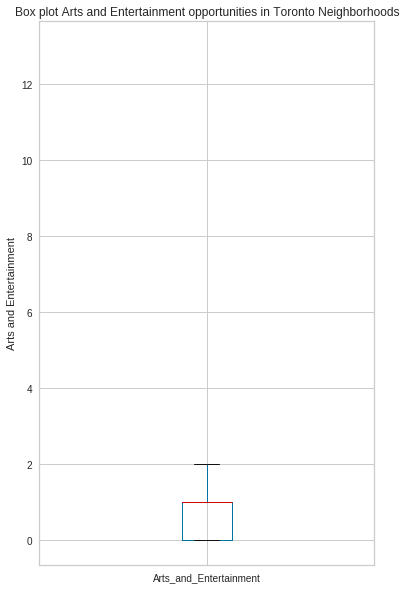

In [57]:
df_arts= neighborhood_df[['Neighborhood_x', 'Arts_and_Entertainment']].set_index('Neighborhood_x')
df_arts.plot(kind='box', figsize=(6, 10))

plt.title('Box plot Arts and Entertainment opportunities in Toronto Neighborhoods')
plt.ylabel('Arts and Entertainment')
plt.savefig('AandEBox.jpeg')
plt.show()

With the boxplot we can create groups for Arts and Entertainment opportunities.    
 
- 0 will be classified as NO ARTS AND ENTERTAINMENT OPPORTUNIIES
- 1 to 2 will be classified as FEW ARTS AND ENTERTAINMENT OPPORTUNIIES 
- 3 to 5 will be classified as FAIR NUMBER OF ARTS AND ENTERTAINMENT OPPORTUNIIES
- 6 and above will be classified as LARGE NUMBER OF ARTS AND ENTERTAINMENT OPPORTUNIIES

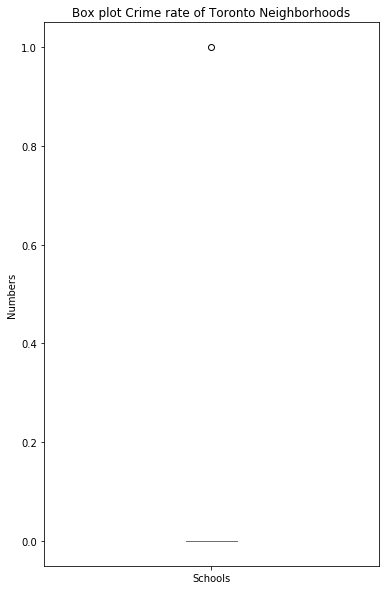

In [18]:
df_school= neighborhood_df[['Neighborhood_x', 'Schools']].set_index('Neighborhood_x')
df_school.plot(kind='box', figsize=(6, 10))

plt.title('Box plot Crime rate of Toronto Neighborhoods')
plt.ylabel('Numbers')

plt.show()

The School availability dataset is very sparse and does not provide any useable information

In [19]:
from sklearn.cluster import KMeans 

print('Libraries imported.')

Libraries imported.


In [2]:
neighborhood_df= pd.read_csv('Neighborhood_Dataset.csv')
neighborhood_df.head()

,Neighborhood_x,AveragePrice$x10^3,Hood_ID,Lat,Long,Crime count,Arts_and_Entertainment,Schools
0,Agincourt North,668,129,43.805598,-79.273155,250,1.0,0.0
1,Agincourt South-Malvern West,559,128,43.786654,-79.268895,293,1.0,0.0
2,Alderwood,869,20,43.606141,-79.541045,95,1.0,0.0
3,Annex,1600,95,43.669766,-79.403552,625,4.0,0.0
4,Banbury-Don Mills,922,42,43.735910,-79.346334,200,0.0,0.0


In [3]:
neighborhood_df.columns

Index(['Neighborhood_x', 'AveragePrice$x10^3', 'Hood_ID', 'Lat', 'Long',
       'Crime count', 'Arts_and_Entertainment', 'Schools'],
      dtype='object')

The school column was dropped as there are few data available

In [20]:
#Drop unecessary colums and rearrange our dataset
df= neighborhood_df.drop(['Neighborhood_x','Lat', 'Long'], axis=1)
df=df[['Hood_ID', 'AveragePrice$x10^3', 'Crime count', 'Arts_and_Entertainment']]
df.head()

,Hood_ID,AveragePrice$x10^3,Crime count,Arts_and_Entertainment
0,129,668,250,1.0
1,128,559,293,1.0
2,20,869,95,1.0
3,95,1600,625,4.0
4,42,922,200,0.0


In [21]:
#Normalize our dataset
from sklearn.preprocessing import StandardScaler

X = df.values[:,1:]
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)


Finding the appropriate K values

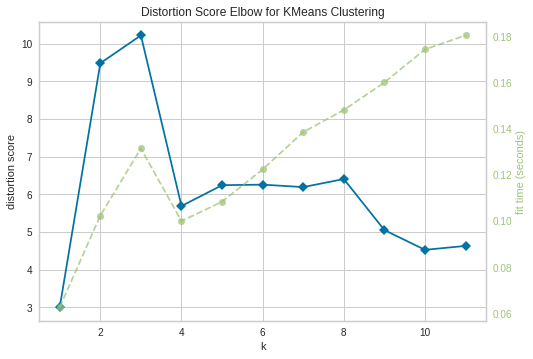

In [28]:
#import elbow
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
k_means = KMeans(init="k-means++", n_init=12)
visualizer = KElbowVisualizer(k_means, k=(1,12))

visualizer.fit(cluster_dataset)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

From the graph above a the elbow point is at a value of 4

In [29]:
#developing the model
num_clusters = 4

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(cluster_dataset)
labels = k_means.labels_

In [30]:
#assigning the cluster labels to the dataset
df["Labels"] = labels
df.head(5)

,Hood_ID,AveragePrice$x10^3,Crime count,Arts_and_Entertainment,Labels
0,129,668,250,1.0,2
1,128,559,293,1.0,2
2,20,869,95,1.0,2
3,95,1600,625,4.0,0
4,42,922,200,0.0,2


In [31]:
#checking the centriod values
df.groupby('Labels').mean()

,Hood_ID,AveragePrice$x10^3,Crime count,Arts_and_Entertainment
Labels,,,,
0,71.027778,1507.555556,162.583333,1.694444
1,60.285714,755.571429,923.428571,2.714286
2,70.360825,758.072165,233.855670,0.453608
3,77.000000,703.000000,1302.000000,13.000000


In [32]:
df.to_csv('hood_kmeans_clusters.csv', index=False) #saving the dataframe to csv

Now we can create a profile for each group, considering the common characteristics of each cluster. 
The 4 clusters are:

- HIGH HOUSING PRICE, AVERAGE CRIME RATE, FEW ENTERTAINMENT OPPORTUNITIES- LABEL 0
- AVERAGE HOUSING PRICE, VERY HIGH CRIME RATE, FAIR NUMBER OF ENTERTAINMENT OPPORTUNITIES- LABEL 1
- AVERAGE HOUSING PRICE, ABOVE AVERAGE CRIME RATE, VERY FEW ENTERTAINMENT OPPORTUNITIES- LABEL 2
- AVERAGE HOUSING PRICE, VERY HIGH CRIME RATE, LARGE NUMBER OF ENTERTAINMENT OPPORTUNITIES- LABEL 3



In [2]:
import pandas as pd
import numpy as np

In [5]:
df= pd.read_csv('hood_kmeans_clusters.csv')
neighborhood_df= pd.read_csv('Neighborhood_Dataset.csv')

In [17]:
#Geting the names of neighborhoods with label 0
kmeans_label_0= df[df['Labels']==0]
kmeans_label_0['Hood_ID']
label_0 = neighborhood_df.loc[neighborhood_df['Hood_ID'].isin(kmeans_label_0['Hood_ID'])]
label_0['Neighborhood_x']

3                                  Annex
8                  Bayview Woods-Steeles
9                   Bedford Park-Nortown
16     Bridle Path-Sunnybrook-York Mills
19      Cabbagetown-South St. James Town
21                             Casa Loma
35                        Dufferin Grove
38              Edenbridge-Humber Valley
41                   Englemount-Lawrence
46                     Forest Hill North
47                     Forest Hill South
49                     Greenwood-Coxwell
52                       High Park North
53                     High Park-Swansea
60                    Humewood-Cedarvale
68                        Kingsway South
70                    Lambton Baby Point
71                      Lansing-Westgate
72                   Lawrence Park North
73                   Lawrence Park South
74                               Leaside
86                   Mount Pleasant East
92                       North Riverdale
93                  North St. James Town
97              

In [18]:
#HIGH HOUSING PRICE, AVERAGE CRIME RATE, FEW ENTERTAINMENT OPPORTUNITIES- LABEL 0
label_0[['Neighborhood_x', 'AveragePrice$x10^3', 'Crime count', 'Arts_and_Entertainment']]

,Neighborhood_x,AveragePrice$x10^3,Crime count,Arts_and_Entertainment
3,Annex,1600,625,4.0
8,Bayview Woods-Steeles,1400,84,1.0
9,Bedford Park-Nortown,1900,237,1.0
16,Bridle Path-Sunnybrook-York Mills,2600,97,0.0
19,Cabbagetown-South St. James Town,990,223,4.0
21,Casa Loma,1700,104,3.0
35,Dufferin Grove,1100,154,2.0
38,Edenbridge-Humber Valley,1400,92,1.0
41,Englemount-Lawrence,1300,171,1.0
46,Forest Hill North,2100,144,3.0


In [19]:
#Geting the names of neighborhoods with label 1
kmeans_label_1= df[df['Labels']==1]
label_1 = neighborhood_df.loc[neighborhood_df['Hood_ID'].isin(kmeans_label_1['Hood_ID'])]
label_1['Neighborhood_x']

6                      Bay Street Corridor
23                   Church-Yonge Corridor
33     Dovercourt-Wallace Emerson-Junction
34                    Downsview-Roding-CFB
66                    Kensington-Chinatown
83                               Moss Park
125                 West Humber-Clairville
Name: Neighborhood_x, dtype: object

In [20]:
#Examining the cluster
#AVERAGE HOUSING PRICE, VERY HIGH CRIME RATE, FAIR NUMBER OF ENTERTAINMENT OPPORTUNITIES- LABEL 1
label_1[['Neighborhood_x', 'AveragePrice$x10^3', 'Crime count', 'Arts_and_Entertainment']]

,Neighborhood_x,AveragePrice$x10^3,Crime count,Arts_and_Entertainment
6,Bay Street Corridor,868,820,5.0
23,Church-Yonge Corridor,690,1575,4.0
33,Dovercourt-Wallace Emerson-Junction,842,592,3.0
34,Downsview-Roding-CFB,662,674,1.0
66,Kensington-Chinatown,858,823,4.0
83,Moss Park,777,928,1.0
125,West Humber-Clairville,592,1052,1.0


In [21]:
#Geting the names of neighborhoods with label 2
kmeans_label_2= df[df['Labels']==2]
label_2 = neighborhood_df.loc[neighborhood_df['Hood_ID'].isin(kmeans_label_2['Hood_ID'])]
label_2['Neighborhood_x']

0                       Agincourt North
1          Agincourt South-Malvern West
2                             Alderwood
4                     Banbury-Don Mills
5                        Bathurst Manor
7                       Bayview Village
10              Beechborough-Greenbrook
11                              Bendale
12                Birchcliffe-Cliffside
13                          Black Creek
14                          Blake-Jones
15                 Briar Hill-Belgravia
17                      Broadview North
18                  Brookhaven-Amesbury
20                   Caledonia-Fairbank
22               Centennial Scarborough
24                  Clairlea-Birchmount
25                         Clanton Park
26                           Cliffcrest
27               Corso Italia-Davenport
28                        Crescent Town
29                             Danforth
30           Danforth Village-East York
31                   Don Valley Village
32                          Dorset Park


In [22]:
#Examining the cluster
#AVERAGE HOUSING PRICE, ABOVE AVERAGE CRIME RATE, VERY FEW ENTERTAINMENT OPPORTUNITIES- LABEL 2
label_2[['Neighborhood_x', 'AveragePrice$x10^3', 'Crime count', 'Arts_and_Entertainment']]

,Neighborhood_x,AveragePrice$x10^3,Crime count,Arts_and_Entertainment
0,Agincourt North,668,250,1.0
1,Agincourt South-Malvern West,559,293,1.0
2,Alderwood,869,95,1.0
4,Banbury-Don Mills,922,200,0.0
5,Bathurst Manor,832,261,2.0
7,Bayview Village,764,146,0.0
10,Beechborough-Greenbrook,863,128,0.0
11,Bendale,606,465,1.0
12,Birchcliffe-Cliffside,845,317,1.0
13,Black Creek,385,379,0.0


In [23]:
#Geting the names of neighborhoods with label 3
kmeans_label_3= df[df['Labels']==3]
label_3 = neighborhood_df.loc[neighborhood_df['Hood_ID'].isin(kmeans_label_3['Hood_ID'])]
label_3['Neighborhood_x']

123    Waterfront Communities-The Island
Name: Neighborhood_x, dtype: object

In [24]:
#Examining the cluster
#AVERAGE HOUSING PRICE, VERY HIGH CRIME RATE, LARGE NUMBER OF ENTERTAINMENT OPPORTUNITIES- LABEL 3
label_3[['Neighborhood_x', 'AveragePrice$x10^3', 'Crime count', 'Arts_and_Entertainment']]

,Neighborhood_x,AveragePrice$x10^3,Crime count,Arts_and_Entertainment
123,Waterfront Communities-The Island,703,1302,13.0


Visualizing the clusters

In [33]:
#!conda install -c conda-forge folium=0.5.0 --yes
import folium

In [36]:
toronto_geo = r'Neighbourhoods.geojson' # geojson file

# toronto latitude and longitude values
latitude = 43.65
longitude = -79.38

toronto_map6 = folium.Map(location=[latitude, longitude], zoom_start=12)


# add pop-up text to each marker on the map
latitudes = list(neighborhood_df.Lat)
longitudes = list(neighborhood_df.Long)
labels = list(neighborhood_df['Neighborhood_x'])

for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker([lat, lng], popup=label).add_to(toronto_map6)    

    

toronto_map6.choropleth(
    geo_data=toronto_geo,
    data=df,
    columns=['Hood_ID', 'Labels'],
    key_on='feature.properties.AREA_SHORT_CODE',
    threshold_scale=[0, 1, 2, 3, 4, 5],
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Similar Neighborhoods in terms of Housing, Crime Rate and Entertainment-Kmeans',
    reset=True
)

In [37]:
toronto_map6.save('kmeansMap.html')#save the html file for viewing in browser
#The ' in some neighborhood names had to be escaped in the html file to enable viewing

## DB-SCAN MODEL

In [38]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
print('Libraries Imported!')

Libraries Imported!


In [39]:
df_db=df[['Hood_ID', 'AveragePrice$x10^3', 'Crime count', 'Arts_and_Entertainment']]
df_db.head()

,Hood_ID,AveragePrice$x10^3,Crime count,Arts_and_Entertainment
0,129,668,250,1.0
1,128,559,293,1.0
2,20,869,95,1.0
3,95,1600,625,4.0
4,42,922,200,0.0


#### Determining the episilon value

Schubert, E., Sander, J., Ester, M., Kriegel, H. P., & Xu, X. (2017). DBSCAN revisited, revisited: why and how you should (still) use DBSCAN. ACM Transactions on Database Systems (TODS), 42(3), 19.


For two-dimensional data: use default value of minPts=4 (Ester et al., 1996)
For more than 2 dimensions: minPts=2*dim (Sander et al., 1998)

Plot the k-distances with k=minPts (Ester et al., 1996)
Find the 'elbow' in the graph--> The k-distance value is your Epsilon value.

k=minPts=2*2=4

In [40]:
#defining a function to determine the appriopriate episiolon value
def k_distances2(x, k):
    dim0 = x.shape[0]
    dim1 = x.shape[1]
    p=-2*x.dot(x.T)+np.sum(x**2, axis=1).T+ np.repeat(np.sum(x**2, axis=1),dim0,axis=0).reshape(dim0,dim0)
    p = np.sqrt(p)
    p.sort(axis=1)
    p=p[:,:k]
    pm= p.flatten()
    pm= np.sort(pm)
    return p, pm


In [41]:
# Normalizing the data
sklearn.utils.check_random_state(1000)
Clus_dataSet = df_db[['AveragePrice$x10^3', 'Crime count', 'Arts_and_Entertainment']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

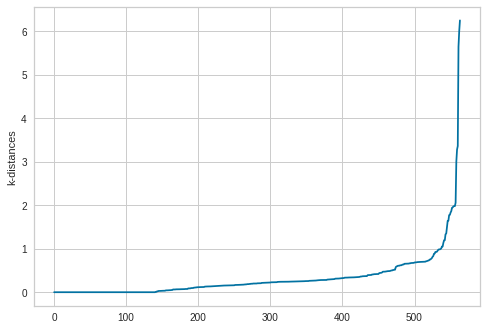

In [42]:
#plotting a graph with defined function to estimate optimal episilon-knee
m, m2= k_distances2(Clus_dataSet, 4)
plt.plot(m2)
plt.ylabel("k-distances")
plt.grid(True)
plt.show()

The knee is at approximately 0.7

In [43]:
#Defining a 2nd function to calculate the optimal episilon
import math
def calculate_kn_distance(X,k):

    kn_distance = []
    for i in range(len(X)):
        eucl_dist = []
        for j in range(len(X)):
            eucl_dist.append(
                math.sqrt(
                    ((X[i,0] - X[j,0]) ** 2) +
                    ((X[i,1] - X[j,1]) ** 2)))

        eucl_dist.sort()
        kn_distance.append(eucl_dist[k])

    return kn_distance

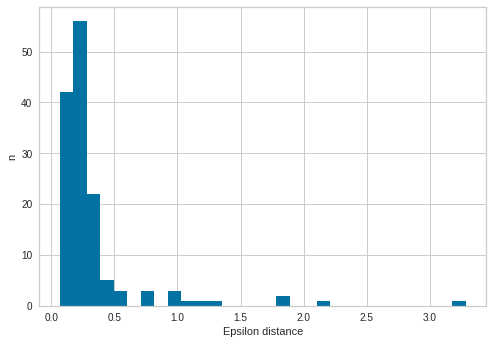

In [44]:
#plotting a graph with the 2nd defined function to estimate optimal episilon
eps_dist = calculate_kn_distance(Clus_dataSet,4)
plt.hist(eps_dist,bins=30)
plt.ylabel('n');
plt.xlabel('Epsilon distance');

A vast majority of points lie within 0.6 units from their 8th nearest neighbor. So, a heuristic approach, could be choosing 0.6 as epsilon parameter.

In [45]:

# Compute DBSCAN
db = DBSCAN(eps=0.6, min_samples=4).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
df_db["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 

df_db.head()

,Hood_ID,AveragePrice$x10^3,Crime count,Arts_and_Entertainment,Clus_Db
0,129,668,250,1.0,0
1,128,559,293,1.0,0
2,20,869,95,1.0,0
3,95,1600,625,4.0,-1
4,42,922,200,0.0,1


Label -1 represents outliers

In [46]:
realClusterNum #actual clusters in the dataset excluding the outliers

4

In [47]:
clusterNum #total number of clusters including the outliers

5

In [48]:
#checking the centriod values
df_db.groupby("Clus_Db").mean()

,Hood_ID,AveragePrice$x10^3,Crime count,Arts_and_Entertainment
Clus_Db,,,,
-1,74.222222,1312.148148,416.185185,2.925926
0,71.657895,866.105263,237.973684,1.000000
1,66.338235,836.764706,210.161765,0.000000
2,88.000000,739.250000,260.250000,2.000000
3,72.750000,1400.000000,172.750000,3.000000


In [51]:
df_db.to_csv('hood_dbscan_clusters.csv', index=False) #saving the dataframe to csv

Now we can create a profile for each group, considering the common characteristics of each cluster. 
The 4 clusters are:

- ABOVE AVERAGE HOUSING PRICE, ABOVE AVERAGE CRIME RATE, FEW ENTERTAINMENT OPPORTUNITIES- LABEL 0
- AVERAGE HOUSING PRICE, ABOVE AVERAGE CRIME RATE, NO ENTERTAINMENT OPPORTUNITIES- LABEL 1
- AVERAGE HOUSING PRICE, ABOVE AVERAGE CRIME RATE, FEW ENTERTAINMENT OPPORTUNITIES- LABEL 2  
- HIGH HOUSING PRICE, AVERAGE CRIME RATE, FAIR AMOUNT OF  ENTERTAINMENT OPPORTUNITIES- LABEL 3  
LABEL **-1** is for outliers

In [25]:
df_db= pd.read_csv('hood_dbscan_clusters.csv')

In [27]:
#Geting the names of neighborhoods with label 0
dbscan_label_0= df_db[df_db['Clus_Db']==0]
db_label_0 = neighborhood_df.loc[neighborhood_df['Hood_ID'].isin(dbscan_label_0['Hood_ID'])]
db_label_0['Neighborhood_x']

0                        Agincourt North
1           Agincourt South-Malvern West
2                              Alderwood
8                  Bayview Woods-Steeles
11                               Bendale
12                 Birchcliffe-Cliffside
15                  Briar Hill-Belgravia
20                    Caledonia-Fairbank
24                   Clairlea-Birchmount
30            Danforth Village-East York
31                    Don Valley Village
34                  Downsview-Roding-CFB
37                         Old East York
38              Edenbridge-Humber Valley
39                         Eglinton East
41                   Englemount-Lawrence
45                       Flemingdon Park
50                             Guildwood
52                       High Park North
54                        Highland Creek
56                        Humber Heights
63                         Junction Area
67         Kingsview Village-The Westway
74                               Leaside
81              

In [28]:
#Examining the cluster
#ABOVE AVERAGE HOUSING PRICE, ABOVE AVERAGE CRIME RATE, FEW ENTERTAINMENT OPPORTUNITIES- LABEL 0
db_label_0[['Neighborhood_x', 'AveragePrice$x10^3', 'Crime count', 'Arts_and_Entertainment']]

,Neighborhood_x,AveragePrice$x10^3,Crime count,Arts_and_Entertainment
0,Agincourt North,668,250,1.0
1,Agincourt South-Malvern West,559,293,1.0
2,Alderwood,869,95,1.0
8,Bayview Woods-Steeles,1400,84,1.0
11,Bendale,606,465,1.0
12,Birchcliffe-Cliffside,845,317,1.0
15,Briar Hill-Belgravia,724,250,1.0
20,Caledonia-Fairbank,816,58,1.0
24,Clairlea-Birchmount,706,400,1.0
30,Danforth Village-East York,977,112,1.0


In [29]:
#Geting the names of neighborhoods with label 1
dbscan_label_1= df_db[df_db['Clus_Db']==1]
db_label_1 = neighborhood_df.loc[neighborhood_df['Hood_ID'].isin(dbscan_label_1['Hood_ID'])]
db_label_1['Neighborhood_x']

4                     Banbury-Don Mills
7                       Bayview Village
10              Beechborough-Greenbrook
13                          Black Creek
14                          Blake-Jones
17                      Broadview North
18                  Brookhaven-Amesbury
22               Centennial Scarborough
25                         Clanton Park
26                           Cliffcrest
27               Corso Italia-Davenport
29                             Danforth
32                          Dorset Park
36                    East End-Danforth
40                     Elms-Old Rexdale
42       Eringate-Centennial-West Deane
43       Eringate-Centennial-West Deane
44                  Etobicoke West Mall
48               Glenfield-Jane Heights
51                           Henry Farm
55                    Hillcrest Village
57                        Humber Summit
58                 Humberlea-Pelmo Park
59                           Humbermede
60                   Humewood-Cedarvale


In [30]:
#Examining the cluster
#AVERAGE HOUSING PRICE, ABOVE AVERAGE CRIME RATE, NO ENTERTAINMENT OPPORTUNITIES- LABEL 1
db_label_1[['Neighborhood_x', 'AveragePrice$x10^3', 'Crime count', 'Arts_and_Entertainment']]

,Neighborhood_x,AveragePrice$x10^3,Crime count,Arts_and_Entertainment
4,Banbury-Don Mills,922,200,0.0
7,Bayview Village,764,146,0.0
10,Beechborough-Greenbrook,863,128,0.0
13,Black Creek,385,379,0.0
14,Blake-Jones,1100,81,0.0
17,Broadview North,892,51,0.0
18,Brookhaven-Amesbury,674,172,0.0
22,Centennial Scarborough,866,53,0.0
25,Clanton Park,779,151,0.0
26,Cliffcrest,1000,230,0.0


In [31]:
#Geting the names of neighborhoods with label 2
dbscan_label_2= df_db[df_db['Clus_Db']==2]
db_label_2 = neighborhood_df.loc[neighborhood_df['Hood_ID'].isin(dbscan_label_2['Hood_ID'])]
db_label_2['Neighborhood_x']

5          Bathurst Manor
75        Little Portugal
80               Milliken
87    Mount Pleasant West
Name: Neighborhood_x, dtype: object

In [32]:
#Examining the cluster
#AVERAGE HOUSING PRICE, ABOVE AVERAGE CRIME RATE, FEW ENTERTAINMENT OPPORTUNITIES- LABEL 2
db_label_2[['Neighborhood_x', 'AveragePrice$x10^3', 'Crime count', 'Arts_and_Entertainment']]

,Neighborhood_x,AveragePrice$x10^3,Crime count,Arts_and_Entertainment
5,Bathurst Manor,832,261,2.0
75,Little Portugal,736,154,2.0
80,Milliken,657,311,2.0
87,Mount Pleasant West,732,315,2.0


In [33]:
#Geting the names of neighborhoods with label 3
dbscan_label_3= df_db[df_db['Clus_Db']==3]
db_label_3 = neighborhood_df.loc[neighborhood_df['Hood_ID'].isin(dbscan_label_3['Hood_ID'])]
db_label_3['Neighborhood_x']

97      Palmerston-Little Italy
99     Playter Estates-Danforth
117                 The Beaches
120           Trinity-Bellwoods
Name: Neighborhood_x, dtype: object

In [34]:
#Examining the cluster
#HIGH HOUSING PRICE, AVERAGE CRIME RATE, FAIR AMOUNT OF ENTERTAINMENT OPPORTUNITIES- LABEL 3
db_label_3[['Neighborhood_x', 'AveragePrice$x10^3', 'Crime count', 'Arts_and_Entertainment']]

,Neighborhood_x,AveragePrice$x10^3,Crime count,Arts_and_Entertainment
97,Palmerston-Little Italy,1400,152,3.0
99,Playter Estates-Danforth,1600,138,3.0
117,The Beaches,1300,173,3.0
120,Trinity-Bellwoods,1300,228,3.0


In [35]:
#Geting the names of neighborhoods outliers
dbscan_outliers= df_db[df_db['Clus_Db']==-1]
db_outliers = neighborhood_df.loc[neighborhood_df['Hood_ID'].isin(dbscan_outliers['Hood_ID'])]
db_outliers['Neighborhood_x']

3                                    Annex
6                      Bay Street Corridor
9                     Bedford Park-Nortown
16       Bridle Path-Sunnybrook-York Mills
19        Cabbagetown-South St. James Town
21                               Casa Loma
23                   Church-Yonge Corridor
28                           Crescent Town
33     Dovercourt-Wallace Emerson-Junction
35                          Dufferin Grove
46                       Forest Hill North
47                       Forest Hill South
49                       Greenwood-Coxwell
53                       High Park-Swansea
66                    Kensington-Chinatown
68                          Kingsway South
70                      Lambton Baby Point
73                     Lawrence Park South
83                               Moss Park
91                                 Niagara
93                    North St. James Town
106                    Rosedale-Moore Park
112                        South Riverdale
113        

In [36]:
#Examining the cluster
#OUTLIERS
db_outliers[['Neighborhood_x', 'AveragePrice$x10^3', 'Crime count', 'Arts_and_Entertainment']]

,Neighborhood_x,AveragePrice$x10^3,Crime count,Arts_and_Entertainment
3,Annex,1600,625,4.0
6,Bay Street Corridor,868,820,5.0
9,Bedford Park-Nortown,1900,237,1.0
16,Bridle Path-Sunnybrook-York Mills,2600,97,0.0
19,Cabbagetown-South St. James Town,990,223,4.0
21,Casa Loma,1700,104,3.0
23,Church-Yonge Corridor,690,1575,4.0
28,Crescent Town,485,185,2.0
33,Dovercourt-Wallace Emerson-Junction,842,592,3.0
35,Dufferin Grove,1100,154,2.0


In [50]:
db_outliers.to_csv('hood_dbscan_outliers.csv', index=False) #saving the dataframe to csv

Visualizing the clusters

In [71]:
toronto_geo = r'Neighbourhoods.geojson' # geojson file

# toronto latitude and longitude values
latitude = 43.65
longitude = -79.38

toronto_map7 = folium.Map(location=[latitude, longitude], zoom_start=12)


# add pop-up text to each marker on the map
latitudes = list(neighborhood_df.Lat)
longitudes = list(neighborhood_df.Long)
labels = list(neighborhood_df['Neighborhood_x'])

for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker([lat, lng], popup=label).add_to(toronto_map7)    


toronto_map7.choropleth(
    geo_data=toronto_geo,
    data=df_db,
    columns=['Hood_ID', 'Clus_Db'],
    key_on='feature.properties.AREA_SHORT_CODE',
    threshold_scale=[-1, 0, 1, 2, 3,4],
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Similar Neighborhoods in terms of Housing, Crime Rate and Entertainment, -1 for outliers',
    reset=True
)

In [73]:
toronto_map7.save('torontomap7.html')#save the html file for viewing in browser

# HIERARCHICAL CLUSTERING- Agglomerative

In [62]:
import numpy as np 
import pandas as pd
from scipy import ndimage 
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
from matplotlib import pyplot as plt 
from sklearn import manifold, datasets 
from sklearn.cluster import AgglomerativeClustering 

%matplotlib inline
print('Libraries imported!')

Libraries imported!


In [2]:
#import cleaned dataset
neighborhood_df= pd.read_csv('Neighborhood_Dataset.csv')
neighborhood_df.head()

,Neighborhood_x,AveragePrice$x10^3,Hood_ID,Lat,Long,Crime count,Arts_and_Entertainment,Schools
0,Agincourt North,668,129,43.805598,-79.273155,250,1.0,0.0
1,Agincourt South-Malvern West,559,128,43.786654,-79.268895,293,1.0,0.0
2,Alderwood,869,20,43.606141,-79.541045,95,1.0,0.0
3,Annex,1600,95,43.669766,-79.403552,625,4.0,0.0
4,Banbury-Don Mills,922,42,43.735910,-79.346334,200,0.0,0.0


In [63]:
df_h=neighborhood_df[['Hood_ID', 'AveragePrice$x10^3', 'Crime count', 'Arts_and_Entertainment']]

In [65]:
# selecting featureset
featureset = df_h[['AveragePrice$x10^3', 'Crime count', 'Arts_and_Entertainment' ]]

In [66]:
#Normalizing the featureset
from sklearn.preprocessing import MinMaxScaler
x = featureset.values #returns a numpy array
min_max_scaler = MinMaxScaler()
feature_mtx = min_max_scaler.fit_transform(x)

In [67]:
#Calculating the distance matrix
import scipy
leng = feature_mtx.shape[0]
D = scipy.zeros([leng,leng])
for i in range(leng):
    for j in range(leng):
        D[i,j] = scipy.spatial.distance.euclidean(feature_mtx[i], feature_mtx[j])

Determining the right method and number of clusters

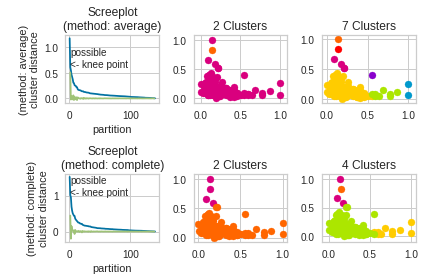

In [68]:
import numpy as np
import scipy.cluster.hierarchy as hac

fig, axes23 = plt.subplots(2, 3)

for method, axes in zip(['average', 'complete'], axes23):
    z = hac.linkage(feature_mtx, method=method)

    # Plotting
    axes[0].plot(range(1, len(z)+1), z[::-1, 2])
    knee = np.diff(z[::-1, 2], 2)
    axes[0].plot(range(2, len(z)), knee)

    num_clust1 = knee.argmax() + 2
    knee[knee.argmax()] = 0
    num_clust2 = knee.argmax() + 2

    axes[0].text(num_clust1, z[::-1, 2][num_clust1-1], 'possible\n<- knee point')

    part1 = hac.fcluster(z, num_clust1, 'maxclust')
    part2 = hac.fcluster(z, num_clust2, 'maxclust')

    clr = ['#2200CC' ,'#D9007E' ,'#FF6600' ,'#FFCC00' ,'#ACE600' ,'#0099CC' ,
    '#8900CC' ,'#FF0000' ,'#FF9900' ,'#FFFF00' ,'#00CC01' ,'#0055CC']

    for part, ax in zip([part1, part2], axes[1:]):
        for cluster in set(part):
            ax.scatter(feature_mtx[part == cluster, 0], feature_mtx[part == cluster, 1], 
                       color=clr[cluster])

    m = '\n(method: {})'.format(method)
    plt.setp(axes[0], title='Screeplot{}'.format(m), xlabel='partition',
             ylabel='{}\ncluster distance'.format(m))
    plt.setp(axes[1], title='{} Clusters'.format(num_clust1))
    plt.setp(axes[2], title='{} Clusters'.format(num_clust2))

plt.tight_layout()
plt.show()

The out shows that using **complete** method for linkage with 4 clusters will provide appropraite representation of the dataset clustering

In [69]:
#creating the model
import pylab
import scipy.cluster.hierarchy
Z = hierarchy.linkage(D, 'complete')

/home/karaktah/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  after removing the cwd from sys.path.


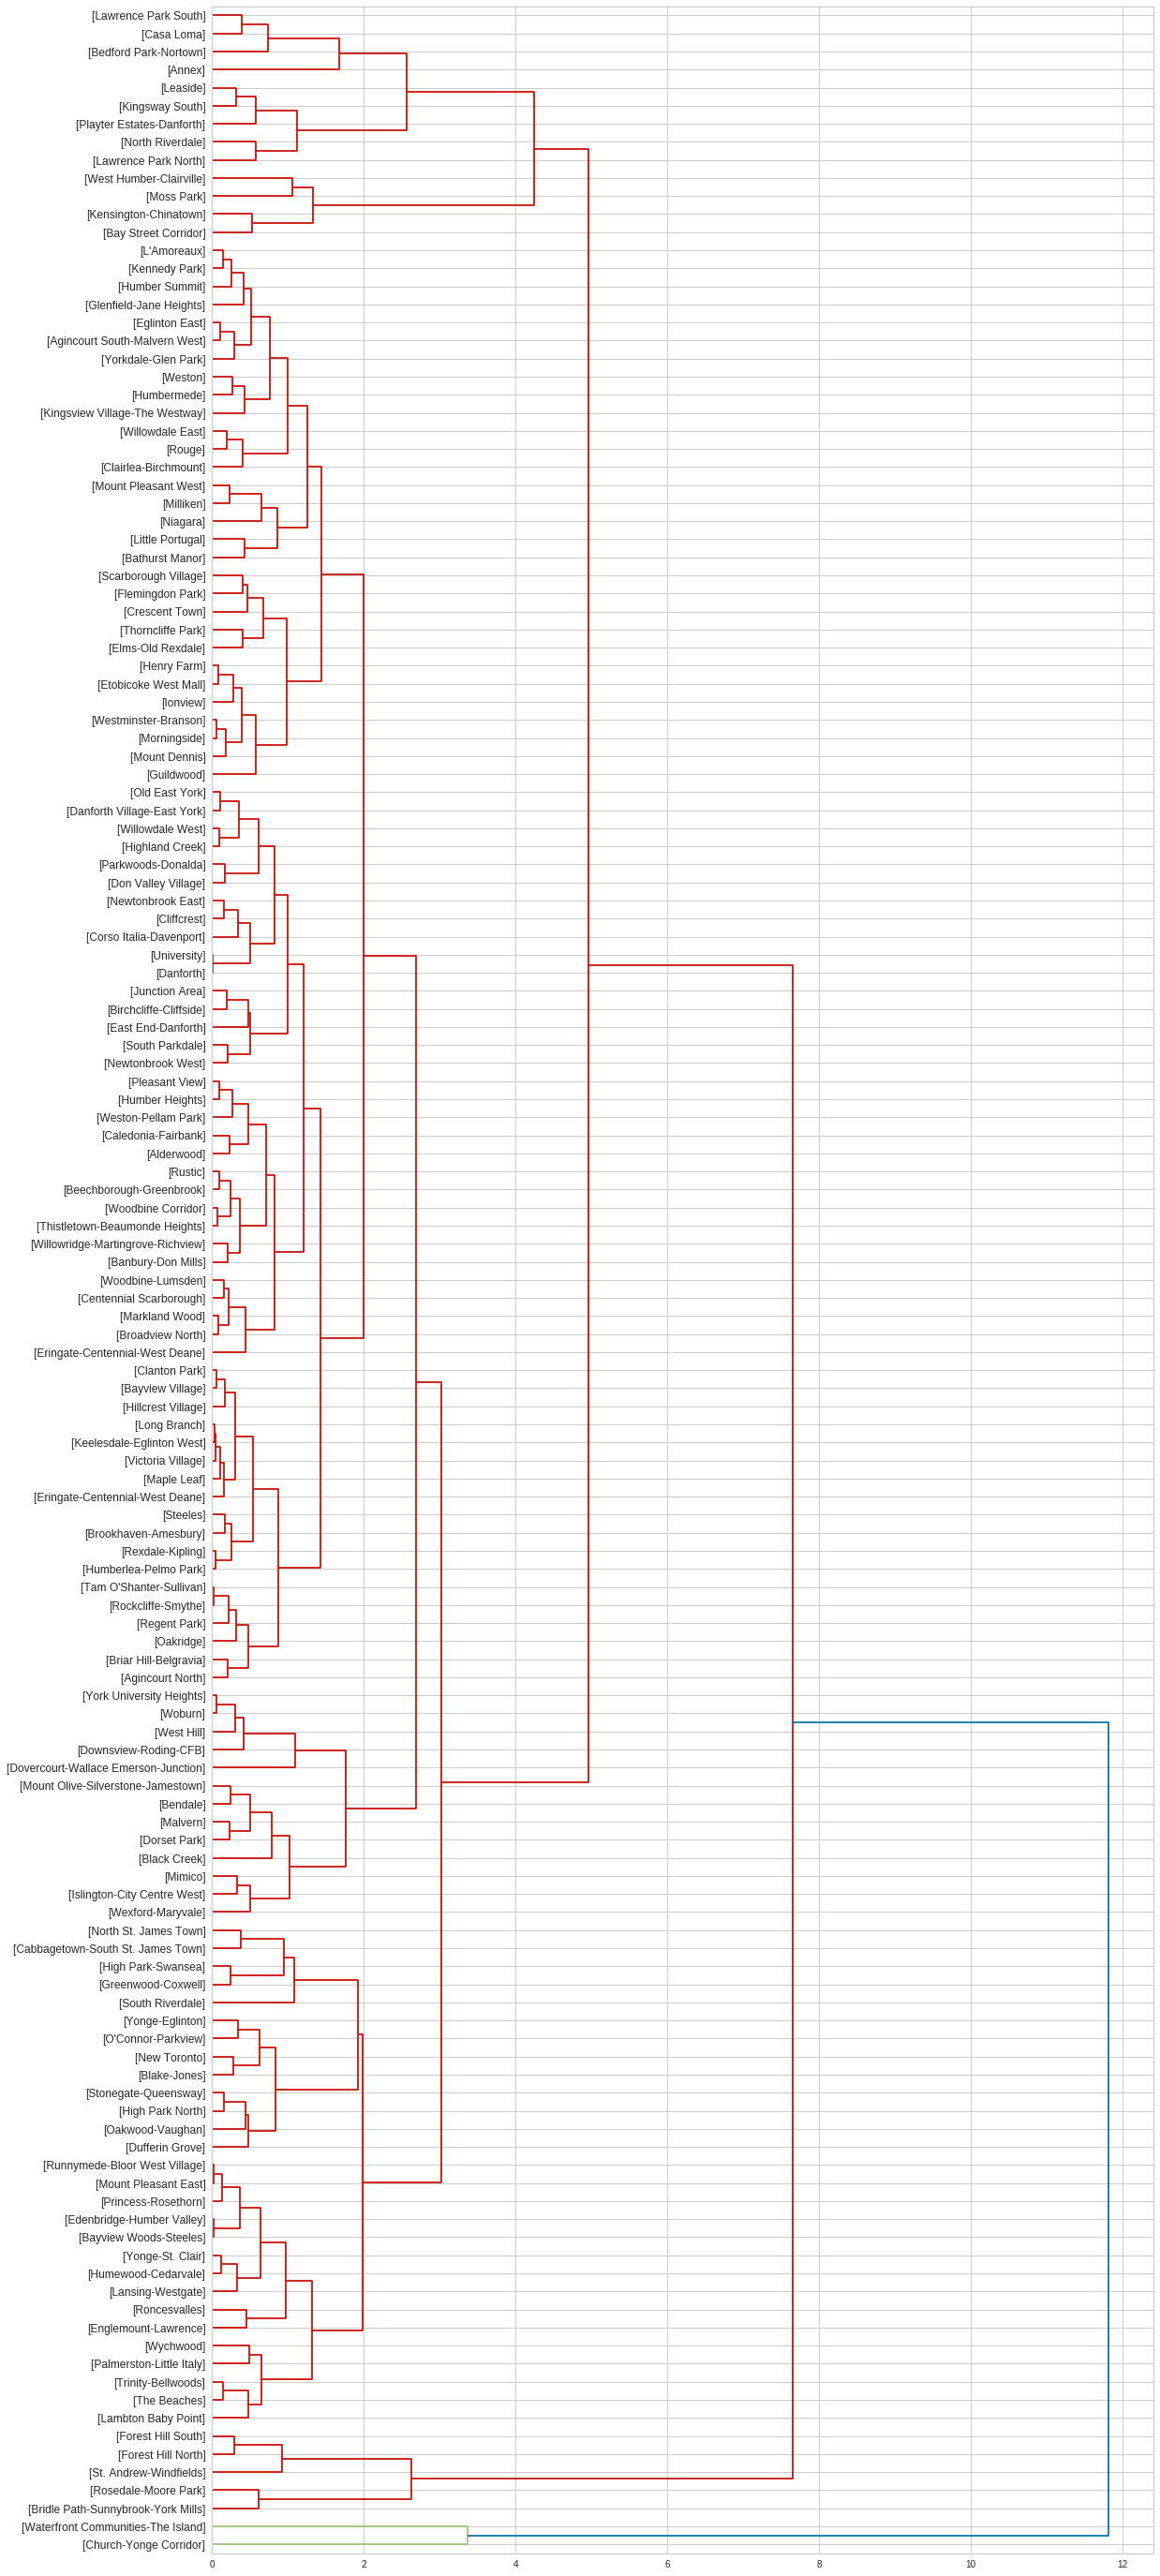

In [71]:
#Plotting the dendrogram
fig = pylab.figure(figsize=(18,50))
def llf(id):
    return '[%s]' % (neighborhood_df['Neighborhood_x'][id])
    
dendro = hierarchy.dendrogram(Z,  leaf_label_func=llf, leaf_rotation=0, leaf_font_size =12, orientation = 'right')
fig.savefig('dendrogram.png', bbox_inches='tight')

Examining the dendogram, a jump is seen close to a distance of 4, if we place a straight line through approximately 3.75 distance tick, we will get 5 clusters, if the line is placed a little above the the 4 distance tick, we will have 4 clusters. Since the descision is to go with either 5 or 4 clusters, i will make a choice of 4 clusters as the **elbow method** also suggests 4 clusters.

In [72]:
#determining clusters
from scipy.cluster.hierarchy import fcluster
clusters = fcluster(Z, 4, criterion='maxclust')
#clusters = fcluster(Z, 4, criterion='distance')

In [73]:
# adding cluster labels to dataset
df_h['Clusters']=clusters
df_h.head()

/home/karaktah/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Hood_ID,AveragePrice$x10^3,Crime count,Arts_and_Entertainment,Clusters
0,129,668,250,1.0,3
1,128,559,293,1.0,3
2,20,869,95,1.0,3
3,95,1600,625,4.0,4
4,42,922,200,0.0,3


In [74]:
#checking the centriod values
df_h.groupby("Clusters").mean()


,Hood_ID,AveragePrice$x10^3,Crime count,Arts_and_Entertainment
Clusters,,,,
1,76.000000,696.500000,1438.500000,8.500000
2,76.400000,2340.000000,183.600000,1.600000
3,70.041322,847.181818,225.743802,0.694215
4,67.076923,1399.615385,399.461538,2.153846


In [75]:
df_h.to_csv('hood_hierachical_clusters.csv', index=False) #saving the dataframe to csv

Now we can create a profile for each group, considering the common characteristics of each cluster. 
The 4 clusters are:

- AVERAGE HOUSING PRICE, VERY HIGH CRIME RATE, LARGE NUMBER OF ENTERTAINMENT OPPORTUNITIES- LABEL 1
- VERY HIGH HOUSING PRICE, AVERAGE CRIME RATE, FEW ENTERTAINMENT OPPORTUNITIES- LABEL 2
- ABOVE AVERAGE HOUSING PRICE, ABOVE AVERAGE CRIME RATE, VERY FEW ENTERTAINMENT OPPORTUNITIES- LABEL 3  
- HIGH HOUSING PRICE, HIGH CRIME RATE, FAIR NUMBER OF  ENTERTAINMENT OPPORTUNITIES- LABEL 4  


In [37]:
df_h= pd.read_csv('hood_hierachical_clusters.csv')

In [38]:
#Geting the names of neighborhoods with label 1
hier_label_1= df_h[df_h['Clusters']==1]
h_label_1 = neighborhood_df.loc[neighborhood_df['Hood_ID'].isin(hier_label_1['Hood_ID'])]
h_label_1['Neighborhood_x']

23                 Church-Yonge Corridor
123    Waterfront Communities-The Island
Name: Neighborhood_x, dtype: object

In [39]:
#Examining the cluster
#AVERAGE HOUSING PRICE, VERY HIGH CRIME RATE, LARGE NUMBER OF ENTERTAINMENT OPPORTUNITIES- LABEL 1
h_label_1[['Neighborhood_x', 'AveragePrice$x10^3', 'Crime count', 'Arts_and_Entertainment']]

,Neighborhood_x,AveragePrice$x10^3,Crime count,Arts_and_Entertainment
23,Church-Yonge Corridor,690,1575,4.0
123,Waterfront Communities-The Island,703,1302,13.0


In [40]:
#Geting the names of neighborhoods with label 2
hier_label_2= df_h[df_h['Clusters']==2]
h_label_2 = neighborhood_df.loc[neighborhood_df['Hood_ID'].isin(hier_label_2['Hood_ID'])]
h_label_2['Neighborhood_x']

16     Bridle Path-Sunnybrook-York Mills
46                     Forest Hill North
47                     Forest Hill South
106                  Rosedale-Moore Park
113                St. Andrew-Windfields
Name: Neighborhood_x, dtype: object

In [41]:
#Examining the cluster
#VERY HIGH HOUSING PRICE, AVERAGE CRIME RATE, FEW ENTERTAINMENT OPPORTUNITIES- LABEL 2
h_label_2[['Neighborhood_x', 'AveragePrice$x10^3', 'Crime count', 'Arts_and_Entertainment']]

,Neighborhood_x,AveragePrice$x10^3,Crime count,Arts_and_Entertainment
16,Bridle Path-Sunnybrook-York Mills,2600,97,0.0
46,Forest Hill North,2100,144,3.0
47,Forest Hill South,2100,85,2.0
106,Rosedale-Moore Park,2600,404,2.0
113,St. Andrew-Windfields,2300,188,1.0


In [42]:
#Geting the names of neighborhoods with label 3
hier_label_3= df_h[df_h['Clusters']==3]
h_label_3 = neighborhood_df.loc[neighborhood_df['Hood_ID'].isin(hier_label_3['Hood_ID'])]
h_label_3['Neighborhood_x']

0                          Agincourt North
1             Agincourt South-Malvern West
2                                Alderwood
4                        Banbury-Don Mills
5                           Bathurst Manor
7                          Bayview Village
8                    Bayview Woods-Steeles
10                 Beechborough-Greenbrook
11                                 Bendale
12                   Birchcliffe-Cliffside
13                             Black Creek
14                             Blake-Jones
15                    Briar Hill-Belgravia
17                         Broadview North
18                     Brookhaven-Amesbury
19        Cabbagetown-South St. James Town
20                      Caledonia-Fairbank
22                  Centennial Scarborough
24                     Clairlea-Birchmount
25                            Clanton Park
26                              Cliffcrest
27                  Corso Italia-Davenport
28                           Crescent Town
29         

In [43]:
#Examining the cluster
#ABOVE AVERAGE HOUSING PRICE, ABOVE AVERAGE CRIME RATE, VERY FEW ENTERTAINMENT OPPORTUNITIES- LABEL 3
h_label_3[['Neighborhood_x', 'AveragePrice$x10^3', 'Crime count', 'Arts_and_Entertainment']]

,Neighborhood_x,AveragePrice$x10^3,Crime count,Arts_and_Entertainment
0,Agincourt North,668,250,1.0
1,Agincourt South-Malvern West,559,293,1.0
2,Alderwood,869,95,1.0
4,Banbury-Don Mills,922,200,0.0
5,Bathurst Manor,832,261,2.0
7,Bayview Village,764,146,0.0
8,Bayview Woods-Steeles,1400,84,1.0
10,Beechborough-Greenbrook,863,128,0.0
11,Bendale,606,465,1.0
12,Birchcliffe-Cliffside,845,317,1.0


In [44]:
#Geting the names of neighborhoods with label 3
hier_label_4= df_h[df_h['Clusters']==4]
h_label_4 = neighborhood_df.loc[neighborhood_df['Hood_ID'].isin(hier_label_4['Hood_ID'])]
h_label_4['Neighborhood_x']

3                         Annex
6           Bay Street Corridor
9          Bedford Park-Nortown
21                    Casa Loma
66         Kensington-Chinatown
68               Kingsway South
72          Lawrence Park North
73          Lawrence Park South
74                      Leaside
83                    Moss Park
92              North Riverdale
99     Playter Estates-Danforth
125      West Humber-Clairville
Name: Neighborhood_x, dtype: object

In [45]:
#Examining the cluster
#HIGH HOUSING PRICE, HIGH CRIME RATE, FAIR NUMBER OF ENTERTAINMENT OPPORTUNITIES- LABEL 4
h_label_4[['Neighborhood_x', 'AveragePrice$x10^3', 'Crime count', 'Arts_and_Entertainment']]

,Neighborhood_x,AveragePrice$x10^3,Crime count,Arts_and_Entertainment
3,Annex,1600,625,4.0
6,Bay Street Corridor,868,820,5.0
9,Bedford Park-Nortown,1900,237,1.0
21,Casa Loma,1700,104,3.0
66,Kensington-Chinatown,858,823,4.0
68,Kingsway South,1700,86,2.0
72,Lawrence Park North,1600,82,0.0
73,Lawrence Park South,1800,86,2.0
74,Leaside,1700,122,1.0
83,Moss Park,777,928,1.0


Visualizing the clusters using folium

In [76]:
import folium

In [77]:
toronto_geo = r'Neighbourhoods.geojson' # geojson file

# toronto latitude and longitude values
latitude = 43.65
longitude = -79.38

toronto_map8 = folium.Map(location=[latitude, longitude], zoom_start=12)


# add pop-up text to each marker on the map
latitudes = list(neighborhood_df.Lat)
longitudes = list(neighborhood_df.Long)
labels = list(neighborhood_df['Neighborhood_x'])

for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker([lat, lng], popup=label).add_to(toronto_map8)    


toronto_map8.choropleth(
    geo_data=toronto_geo,
    data=df_h,
    columns=['Hood_ID', 'Clusters'],
    key_on='feature.properties.AREA_SHORT_CODE',
    threshold_scale=[1, 2, 3, 4, 5],
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Similar Neighborhoods in terms of Housing, Crime Rate and Entertainment-Hierachical Clustering',
    reset=True
)

In [78]:
toronto_map8.save('hierachicalmap.html')#save the html file for viewing in browser

# DISCUSSION


The decision to use 3 different clustering algorithms on the dataset was just to see what kind of clusters could be gotten, this has no bearing on the aim of the project.


The Db-Scan algorithm was the choice algorithm because it has the ability to detect outliers. One hundred and forty (140) Toronto neighborhoods were divided into 4 clusters, of these

27 neighborhoods were outliers (Very High Housing prices, Very High Crime rate or Very High Entertainment opportunities);

4 neighborhoods were in the High Housing Price, Average Crime Rate and Fair Amount of Entertainment Opportunities cluster;

Another 4 neighborhoods were in the Average Housing Price, Above Average Crime Rate, Few Entertainment Opportunities cluster;

68 of the neighborhoods were in the Average Housing Price, Above Average Crime Rate, No Entertainment Opportunities cluster;

The final cluster with the characteristics Above Average Housing Price, Above Average Crime Rate, Few Entertainment Opportunities had 37 neighborhoods.

In comparing the characteristics of the neighborhoods to that of the clusters they were assigned to, I discovered that some neighborhood features were somewhat different from that of their assigned cluster.

# CONCLUSION

The purpose of this project was to place Toronto neighborhoods in categories depending on crime rate, average housing prices, number of schools and arts and entertainment opportunities; this was not totally achievable as data for schools from Foursquare Location data was sparse. 

By employing the DB-SCAN  I was able to get 4 labeled clusters. This will enable anyone migrating to Toronto to filter out neighborhood to reside in based on their preferences. This project provides a starting point in considering potential neighborhoods for residence and reduces the time and energy needed for such research. 
